# Speech Emotion Recognition With Convolutional Neural Network

<H2>Import Libraries<H2>

In [1]:

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
import resampy
import lazy
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Importing the necessary Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, BatchNormalization, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
TESS = "D:\data\Tess"
RAV =r'D:\data\Ravdess\audio_speech_actors_01-24'
SAVEE = "D:\data\Savee"
CREMA = "D:\data\Crema"

# Run one example 
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

<h2>Analysis of 4 Datasets<h2>

In [3]:
dir_list = os.listdir(SAVEE)
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(os.path.join(SAVEE, i))
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df

labels source                       path
0       male_angry  SAVEE   D:\data\Savee\DC_a01.wav
1       male_angry  SAVEE   D:\data\Savee\DC_a02.wav
2       male_angry  SAVEE   D:\data\Savee\DC_a03.wav
3       male_angry  SAVEE   D:\data\Savee\DC_a04.wav
4       male_angry  SAVEE   D:\data\Savee\DC_a05.wav
..             ...    ...                        ...
475  male_surprise  SAVEE  D:\data\Savee\KL_su11.wav
476  male_surprise  SAVEE  D:\data\Savee\KL_su12.wav
477  male_surprise  SAVEE  D:\data\Savee\KL_su13.wav
478  male_surprise  SAVEE  D:\data\Savee\KL_su14.wav
479  male_surprise  SAVEE  D:\data\Savee\KL_su15.wav

[480 rows x 3 columns]

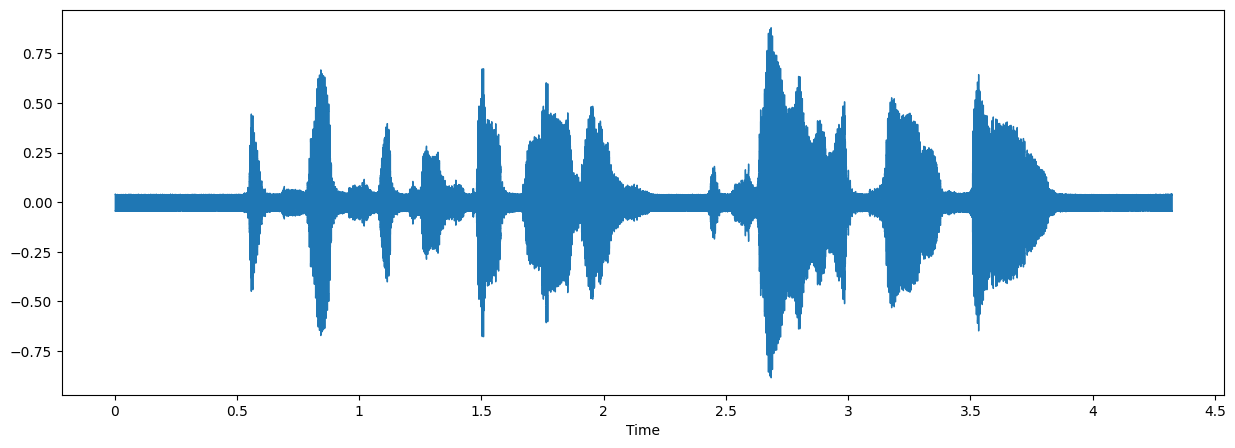

In [4]:
fname = "D:\data\Savee\DC_f11.wav"  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

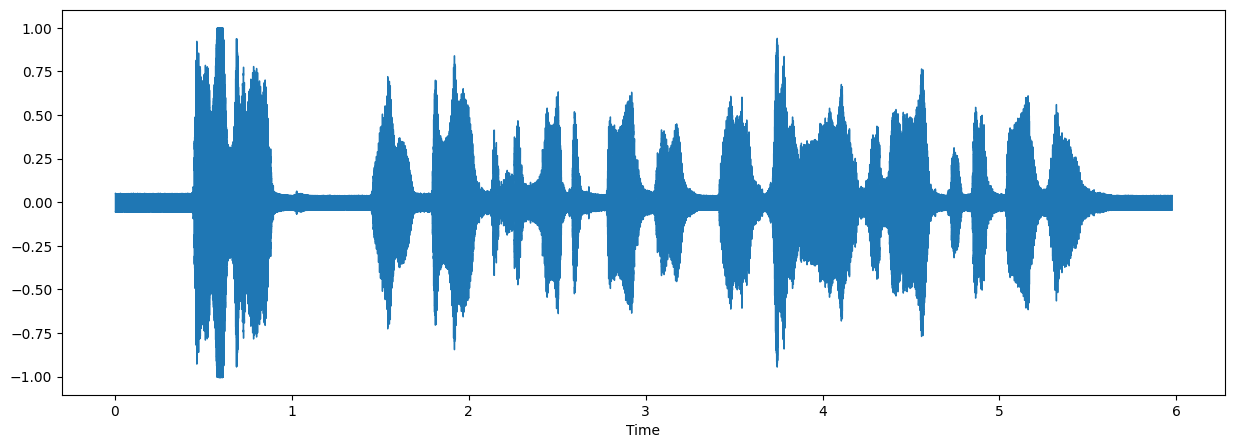

In [5]:
fname = 'D:\data\Savee\DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [6]:
emotion = []
gender = []
path = []
RAV = 'D:\\data\\Ravdess\\audio_speech_actors_01-24\\'  # Ensure the path ends with a separator
dir_list = ['Actor_01', 'Actor_02', 'Actor_03','Actor_04','Actor_05','Actor_06','Actor_07','Actor_08','Actor_09',
            'Actor_10','Actor_11','Actor_12','Actor_13','Actor_14','Actor_15','Actor_16','Actor_17','Actor_18',
            'Actor_19','Actor_20','Actor_21','Actor_22','Actor_23','Actor_24']  #Add relevant directories

for i in dir_list:
    full_dir_path = os.path.join(RAV, i)  # Safely join paths
    try:
        fname = os.listdir(full_dir_path)
        for f in fname:
            part = f.split('.')[0].split('-')
            emotion.append(int(part[2]))
            temp = int(part[6])
            gender.append("female" if temp % 2 == 0 else "male")
            file_path = os.path.join(full_dir_path, f)  # Safely join full path to file
            path.append(file_path)
    except FileNotFoundError as e:
        print(f"Directory not found: {full_dir_path}")

# Create DataFrame and map emotion labels
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})

# Add gender and file paths
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']

# Combine gender and emotion for labels
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'

# Add file paths to the DataFrame
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)

# Drop unnecessary columns
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

# Display value counts for labels
RAV_df.head()

labels   source                                               path
0  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
1  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
2  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
3  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
4  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...

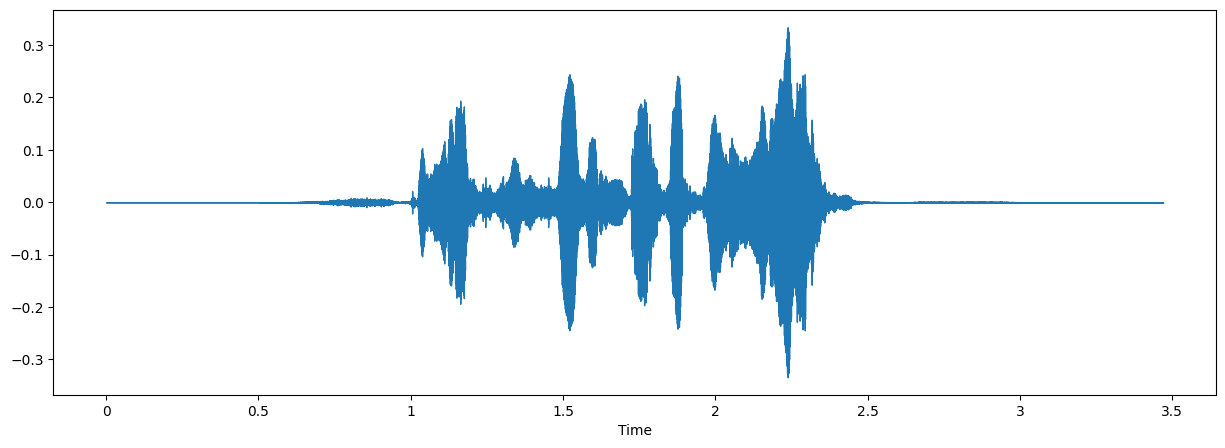

In [7]:
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

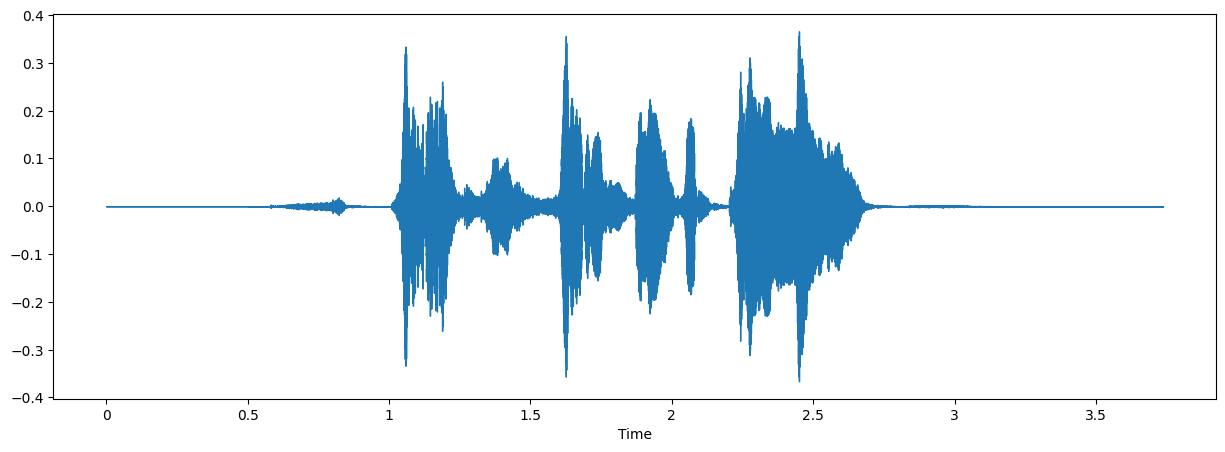

In [8]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [9]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [10]:


# List of directories to process
dir_list = ['OAF_angry', 'YAF_angry', 'OAF_disgust', 'YAF_disgust', 'OAF_fear', 'YAF_fear',
            'OAF_happy', 'YAF_happy', 'OAF_neutral', 'YAF_neutral', 'OAF_pleasant_surprise',
            'YAF_pleasant_surprise', 'OAF_sad', 'YAF_sad']

# Emotion mapping dictionary
emotion_mapping = {
    'OAF_angry': 'female_angry', 'YAF_angry': 'female_angry',
    'OAF_disgust': 'female_disgust', 'YAF_disgust': 'female_disgust',
    'OAF_fear': 'female_fear', 'YAF_fear': 'female_fear',
    'OAF_happy': 'female_happy', 'YAF_happy': 'female_happy',
    'OAF_neutral': 'female_neutral', 'YAF_neutral': 'female_neutral',
    'OAF_pleasant_surprise': 'female_surprise', 'YAF_pleasant_surprise': 'female_surprise',
    'OAF_sad': 'female_sad', 'YAF_sad': 'female_sad'
}

# Process each directory
for i in dir_list:
    full_dir_path = os.path.join(TESS, i)  # Safely join paths
    try:
        fname = os.listdir(full_dir_path)
        for f in fname:
            emotion.append(emotion_mapping.get(i, 'Unknown'))  
            
            path.append(os.path.join(full_dir_path, f))  
    except FileNotFoundError as e:
        print(f"Directory not found: {full_dir_path}")

# Create DataFrame from the lists
TESS_df = pd.DataFrame(emotion, columns=['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df, pd.DataFrame(path, columns=['path'])], axis=1)

# Display value counts for labels
print(TESS_df.labels.value_counts())
TESS_df


Directory not found: D:\data\Tess\YAF_pleasant_surprise
female_angry       400
female_disgust     400
female_fear        400
female_happy       400
female_neutral     400
female_sad         212
female_surprise    200
2                  192
3                  192
4                  192
5                  192
6                  192
7                  192
8                  192
1                   96
Name: labels, dtype: int64


labels source                                               path
0              1   TESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
1              1   TESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
2              1   TESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
3              1   TESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
4              2   TESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
...          ...    ...                                                ...
3847  female_sad   TESS              D:\data\Tess\YAF_sad\YAF_boat_sad.wav
3848  female_sad   TESS              D:\data\Tess\YAF_sad\YAF_bone_sad.wav
3849  female_sad   TESS              D:\data\Tess\YAF_sad\YAF_book_sad.wav
3850  female_sad   TESS            D:\data\Tess\YAF_sad\YAF_bought_sad.wav
3851  female_sad   TESS              D:\data\Tess\YAF_sad\YAF_burn_sad.wav

[3852 rows x 3 columns]

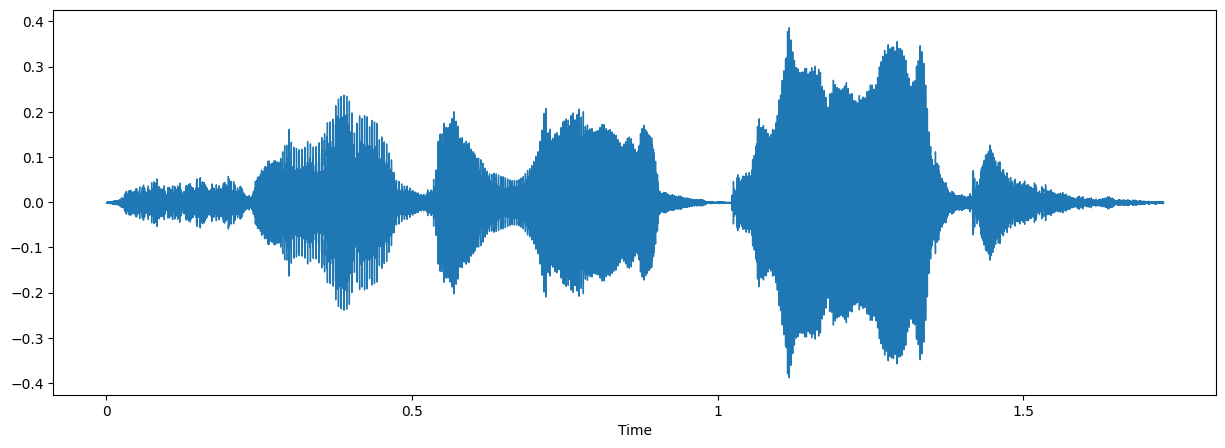

In [11]:
fname ="D:\data\Tess\YAF_fear\YAF_dog_fear.wav" 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [12]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])



['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [13]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(os.path.join(CREMA, i))
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_disgust      673
male_fear         673
male_happy        673
male_angry        672
male_sad          672
female_disgust    605
female_angry      601
female_fear       601
female_happy      601
female_sad        601
male_neutral      577
female_neutral    513
Name: labels, dtype: int64

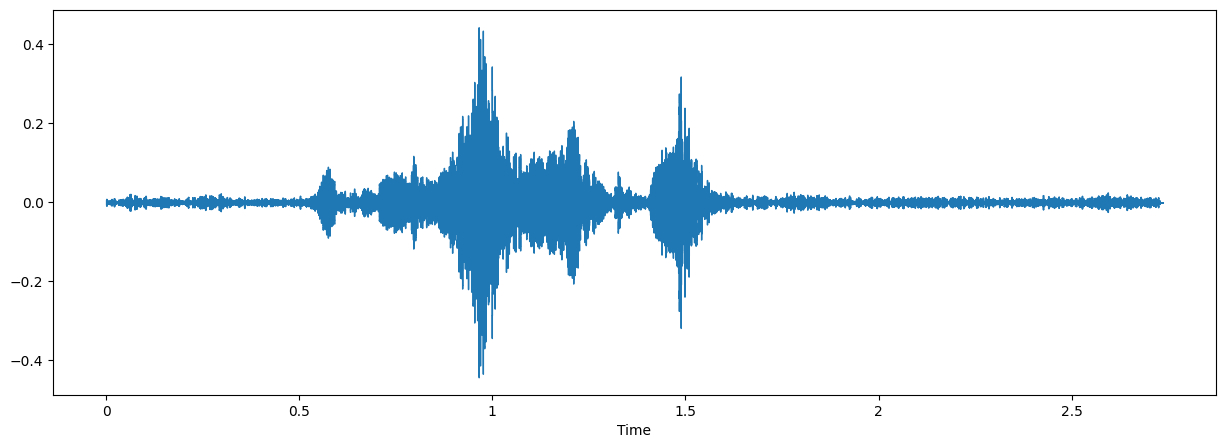

In [14]:
fname =r"D:\data\Crema\1012_IEO_HAP_HI.wav"
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

<h2>Full ONE Data SET<h2>


In [15]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_disgust     1101
female_fear        1097
female_angry       1097
female_happy       1097
female_neutral     1057
female_sad          909
male_neutral        841
male_fear           829
male_happy          829
male_disgust        829
male_angry          828
male_sad            828
female_surprise     296
2                   192
3                   192
4                   192
5                   192
6                   192
7                   192
8                   192
male_surprise       156
1                    96
Name: labels, dtype: int64


In [16]:
df

labels source                               path
0         male_angry  SAVEE           D:\data\Savee\DC_a01.wav
1         male_angry  SAVEE           D:\data\Savee\DC_a02.wav
2         male_angry  SAVEE           D:\data\Savee\DC_a03.wav
3         male_angry  SAVEE           D:\data\Savee\DC_a04.wav
4         male_angry  SAVEE           D:\data\Savee\DC_a05.wav
...              ...    ...                                ...
7457  female_disgust  CREMA  D:\data\Crema\1091_WSI_DIS_XX.wav
7458     female_fear  CREMA  D:\data\Crema\1091_WSI_FEA_XX.wav
7459    female_happy  CREMA  D:\data\Crema\1091_WSI_HAP_XX.wav
7460  female_neutral  CREMA  D:\data\Crema\1091_WSI_NEU_XX.wav
7461      female_sad  CREMA  D:\data\Crema\1091_WSI_SAD_XX.wav

[13234 rows x 3 columns]

In [17]:
ref = pd.read_csv("Data_path.csv")
ref.head()

labels source                      path
0  male_angry  SAVEE  D:\data\Savee\DC_a01.wav
1  male_angry  SAVEE  D:\data\Savee\DC_a02.wav
2  male_angry  SAVEE  D:\data\Savee\DC_a03.wav
3  male_angry  SAVEE  D:\data\Savee\DC_a04.wav
4  male_angry  SAVEE  D:\data\Savee\DC_a05.wav

In [18]:
ref["labels"].unique()

array(['male_angry', 'male_disgust', 'male_fear', 'male_happy',
       'male_neutral', 'male_sad', 'male_surprise', 'female_neutral',
       'female_happy', 'female_sad', 'female_angry', 'female_fear',
       'female_disgust', 'female_surprise', '1', '2', '3', '4', '5', '6',
       '7', '8'], dtype=object)

In [19]:
def noise(data):
    """
    Adding White Noise.
    """
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)   # more noise reduce the value to 0.05
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high=5) * 1000)  # default at 500
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    """
    Stretching the Sound. Note that this expands the dataset slightly.
    """
    data = librosa.effects.time_stretch(data, rate=0.8)
    return data
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    
    # Ensure data is in the correct format
    data = data.astype('float64')
    
    # Call pitch_shift correctly
    data = librosa.effects.pitch_shift(data, 
                                      sr=sample_rate, 
                                      n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
  

def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5, high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.2 / length_change
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0, len(data)), data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

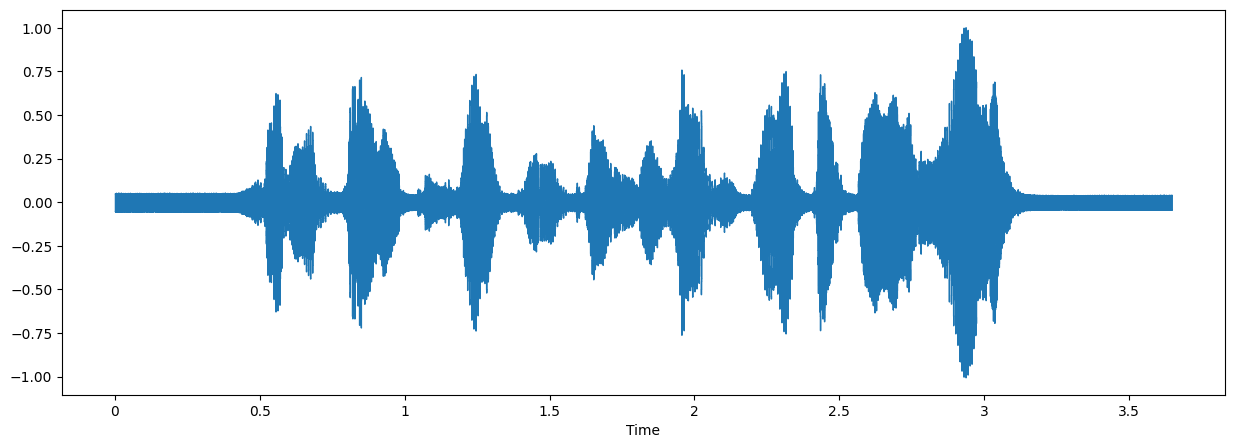

In [20]:
fname = 'D:\data\Savee\DC_a01.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

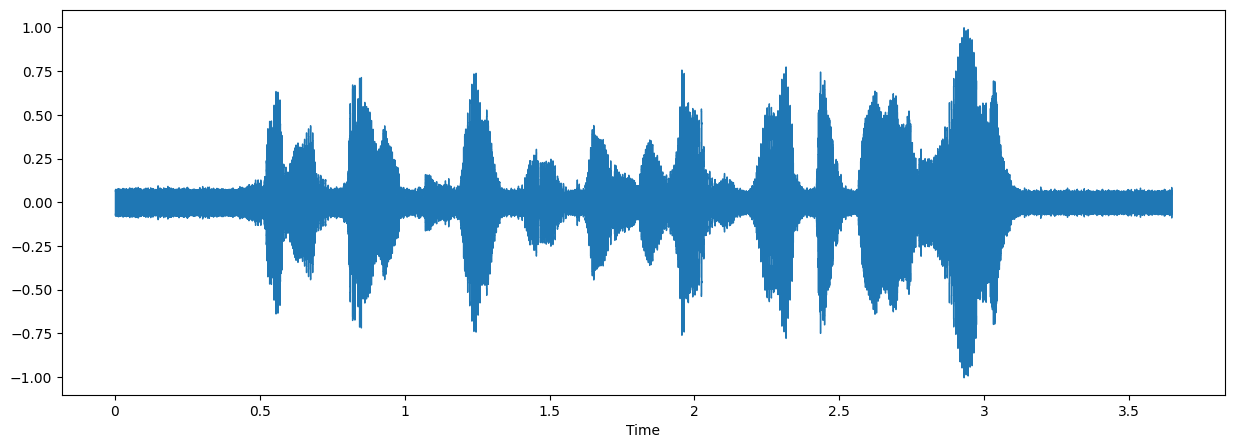

In [21]:
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

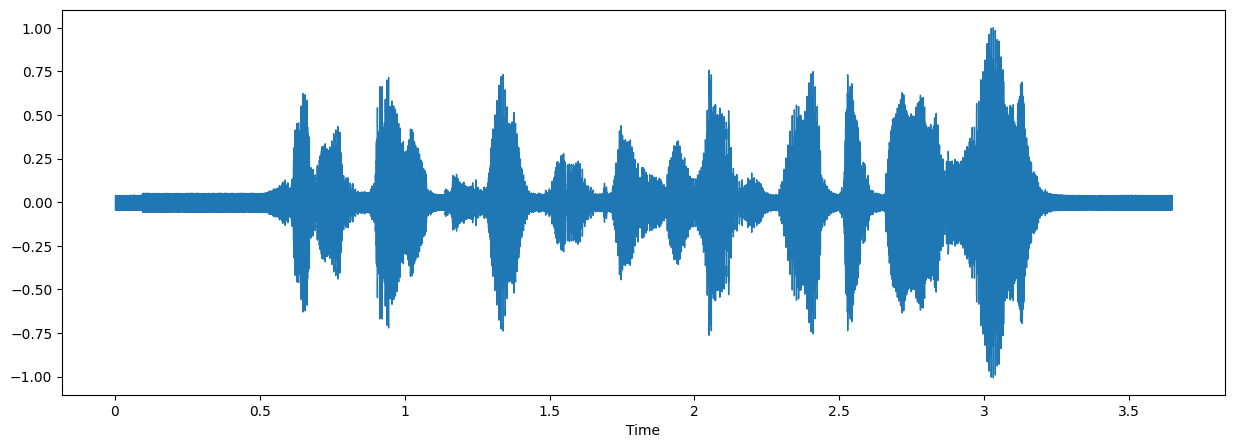

In [22]:
x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

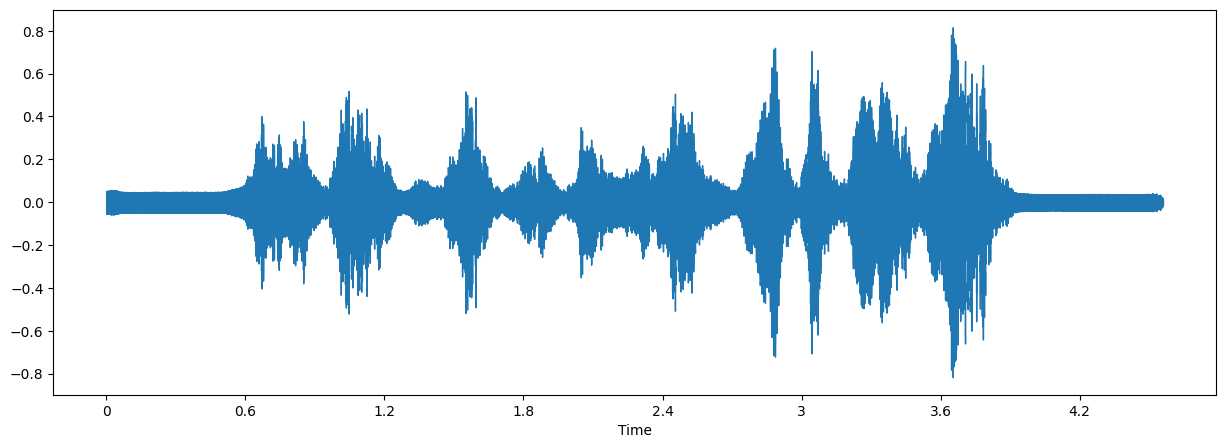

In [23]:
x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

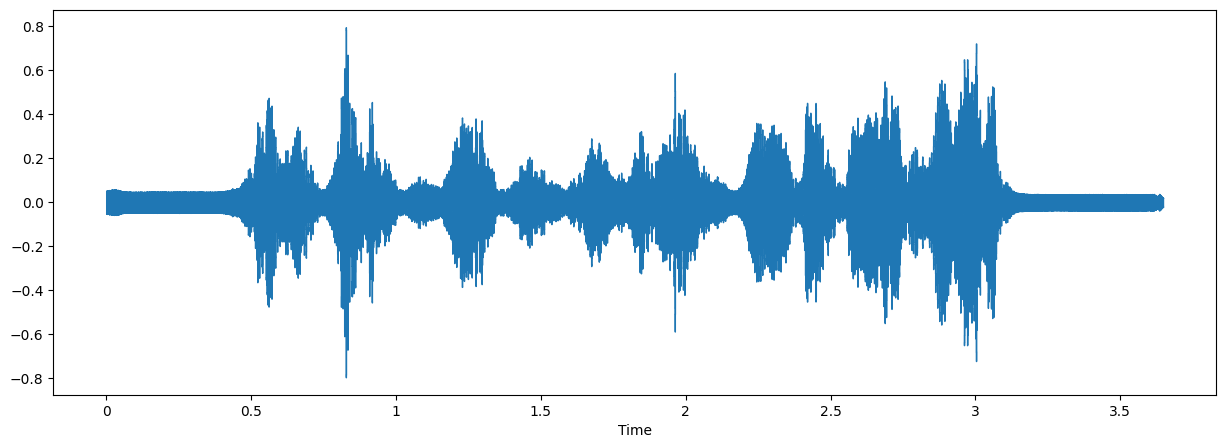

In [24]:
x = pitch(data, sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

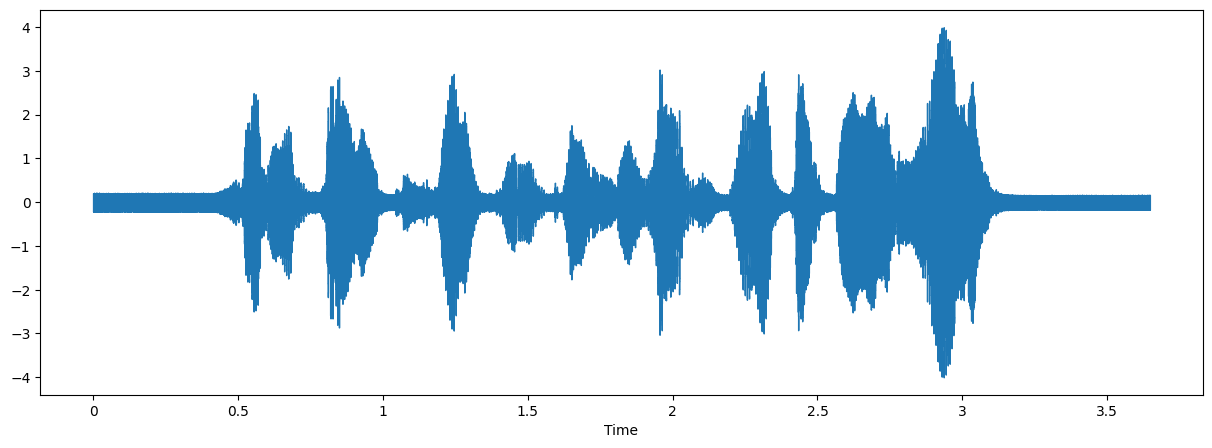

In [25]:
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

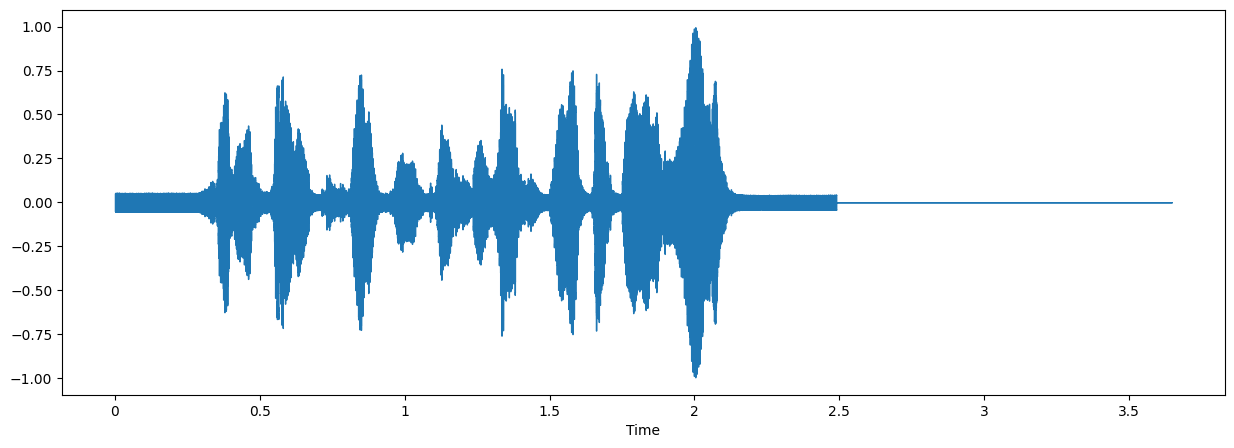

In [26]:
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)


In [ ]:
from tqdm import tqdm
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

 13%|█████████████▎                                                                                           | 1671/13234 [01:48<19:03, 10.11it/s]

In [34]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)




NameError: name 'df_noise' is not defined

In [35]:
df.isnull().sum()

mfcc    0
zcr     0
mel     0
dtype: int64

In [36]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

NameError: name 'df_noise' is not defined

In [37]:
df["labels"].unique()
# Define the values you want to remove
values_to_remove = ['1', '2', '3', '4', '5', '6', '7', '8']

# Use isin() to drop rows where the "labels" column contains any of these values
df = df[~df["labels"].isin(values_to_remove)]

# Check the "labels" column
df["labels"]
df["labels"].unique()


KeyError: 'labels'

In [38]:
df.isnull().sum()

mfcc    0
zcr     0
mel     0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

In [ ]:
# Convert inputs to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure y_train and y_test are 1D before using LabelEncoder
if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=1)
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# One-hot encode the target labels
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

# Check the shapes of the processed data
print(X_train.shape)
print(lb.classes_)



In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)

In [ ]:
import pickle
# Pickle the LabelEncoder object for future use
filename = 'labels.pkl'  # Add .pkl extension for clarity
outfile = open(filename, 'wb')
pickle.dump(lb, outfile)
outfile.close()

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

In [ ]:
preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

In [ ]:
model_path = "./res_model.h5"

model.save(model_path)